## Imports

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from numexpr import evaluate
import os

## Plotting function
This function plot the current state of the simulation (U)

In [41]:
def plot_U(U, mask, cmap):
    """
    Plots the current state of the simulation

    Parameters:
    U (numpy array of floats): The current state of the simulation
    mask (numpy array of bool): The mask (where the walls are in the simulation)

    Returns:
    nothing, but displays the state of U
    """
    plt.cla()
    Uplot = 1.*U
    Uplot[mask] = np.nan
    plt.imshow(Uplot.T, cmap=cmap)
    plt.clim(-3, 3)
    ax = plt.gca()
    ax.invert_yaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)	
    ax.set_aspect('equal')	
    plt.pause(0.001)

## Intialization function

In [42]:
def get_mask(N):
    """
    Returns the mask matrix (location of the walls) of for the simulation of given resolution

    Parameters:
    N (int): Resolution of the simulation

    Returns:
    The mask matrix
    """
    mask = np.zeros((N,N),dtype=bool)
    mask[0,:]  = True
    mask[-1,:] = True
    mask[:,0]  = True
    mask[:,-1] = True
    mask[int(N/4):int(N*9/32),:N-1] = True
    mask[1:N-1,int(N*5/16):int(N*3/8)] = False
    mask[1:N-1,int(N*5/8):int(N*11/16)] = False

    return mask

In [43]:
def get_initial_U(N, mask):
    """
    Return the initial U matrix for the given resolution

    Parameters:
    N (int): Resolution of the simulation    
    mask (numpy array of bool): The mask (where the walls are in the simulation)

    Returns:
    The initial U matrix
    """
    U = np.zeros((N,N))
    U[mask] = 0
    return U

## Implemented NumExpr optimizations
The four following functions are the different optimizations we implemented using numexpr on the computation of the new state of the matrix U. 

They all take the same parameters even though they don't always need all of them, so we can use them interchangeably.

In [45]:
def get_Unew_default(U, Uprev, ULX, URX, ULY, URY, fac):
    laplacian = (ULX + ULY - 4*U + URX + URY)
    return (2*U - Uprev + fac * laplacian)

In [46]:
def get_Unew_numexpr(U, Uprev, ULX, URX, ULY, URY, fac):
    laplacian = evaluate("ULX + ULY - 4*U + URX + URY")
    return evaluate("2*U - Uprev + fac * laplacian")

In [47]:
def get_Unew_numexpr2(U, Uprev, ULX, URX, ULY, URY, fac):
    return evaluate("2*U - Uprev + fac * (ULX + ULY - 4*U + URX + URY)")

In [48]:
def get_Unew_numexpr3(U, Uprev, ULX, URX, ULY, URY, fac):
    return evaluate("2*U - Uprev + fac * (ULX + ULY - 4*U + URX + URY)", optimization='aggressive')

In [50]:
def simulate_finite_difference(boxsize, N, c, tEnd, plotRealTime, plotFinal, cmap, get_Unew):
    """
    Runs a simulation of the double-slit experiment

    Parameters:
    boxsize (float): Size of the box
    N (int): Resolution of the simulation
    c (float): Wave speed
    tEnd (fload): Simulation time
    plotRealTime (boolean): Set to True if we want to plot the simulation live
    plotFinal (boolean): Set to True if we want to see the final result
    
    Returns:
    The final state of the simulation matrix U
    """
    # === Generate mask & initial conditions
    mask = get_mask(N)
    U = get_initial_U(N, mask)
    Uprev = 1.*U

    t = 0

    # === Initialize Mesh ===
    dx = boxsize / N
    dt = (np.sqrt(2)/2) * dx / c
    fac = dt**2 * c**2 / dx**2
    aX = 0   # x-axis
    aY = 1   # y-axis
    R = -1   # right
    L = 1    # left

    # === Initialize grid ===
    xlin = np.linspace(0.5 * dx, boxsize - 0.5*dx, N)

    # === Main simulation loop ===
    while t < tEnd:
        #print(t)
        # === Compute Laplacian ===
        ULX = np.roll(U, L, axis=aX)
        URX = np.roll(U, R, axis=aX)
        ULY = np.roll(U, L, axis=aY)
        URY = np.roll(U, R, axis=aY)
            
        # === Update U ===
        Unew = get_Unew(U, Uprev, ULX, URX, ULY, URY, fac)
        Uprev = 1.*U
        U = 1.*Unew
        
        # === Apply boudary conditions (Dirichlet/inflow) ===
        U[mask] = 0
        U[0,:] = np.sin(20*np.pi*t) * np.sin(np.pi*xlin)**2
        
        # === Update time ===
        t += dt
        
        if (plotRealTime) or (t >= tEnd and plotFinal):
            plot_U(Unew, mask, cmap)
        
    return U

## Experiment
In the cell below, we conduct the experiment that allows us to compare the different optimizations implemented.
We make the resolution parameter vary and compare the performance.

In [70]:
from timeit import default_timer as timer

# === Simulation parameters ===
boxsize        = 1.    # Size of the box
c              = 1.    # Wave Speed
tEnd           = 2.    # Simulation time
plotRealTime   = False  # Set to True for real-time vizualisation
plotFinal      = False

resolutions = [100 * i for i in range(1, 7)]

results_default = []
results_numexpr = []
results_numexpr2 = []
results_numexpr3 = []
results_numexpr4 = []

# Plotting variables
fig = plt.figure(figsize=(2, 2), dpi=80)
cmap = plt.cm.bwr
cmap.set_bad('gray')

for N in resolutions:
    print("N = " + str(N))
    # === Generate mask & initial conditions
    mask = get_mask(N)
    U = get_initial_U(N, mask)
    Uprev = 1.*U

    start = timer()
    res1 = simulate_finite_difference(boxsize, N, c, tEnd, plotRealTime, plotFinal, cmap, get_Unew_default)
    end = timer()

    results_default.append(end - start)
    
    start = timer()
    res2 = simulate_finite_difference(boxsize, N, c, tEnd, plotRealTime, plotFinal, cmap, get_Unew_numexpr)
    end = timer()

    results_numexpr.append(end - start)
    
    start = timer()
    res3 = simulate_finite_difference(boxsize, N, c, tEnd, plotRealTime, plotFinal, cmap, get_Unew_numexpr2)
    end = timer()

    results_numexpr2.append(end - start)
    
    start = timer()
    res4 = simulate_finite_difference(boxsize, N, c, tEnd, plotRealTime, plotFinal, cmap, get_Unew_numexpr3)
    end = timer()

    results_numexpr3.append(end - start)
    
print("Finished running the experiment")

N = 100
N = 200
N = 300
N = 400
N = 500
N = 600
Finished running the experiment


<Figure size 160x160 with 0 Axes>

## Plotting the results
Once the experiment has finished running, we can plot the results and see how each optimization performed.

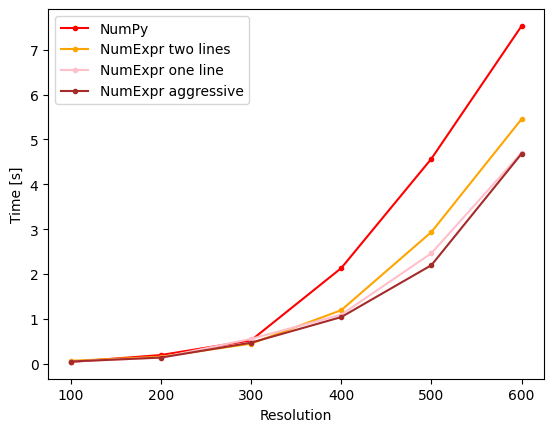

In [71]:
def get_points_xy(resolutions, results):
    points = []

    for i in range(len(resolutions)):
        points.append([resolutions[i], results[i]])
    
        
    data = np.array([points])
    x, y = data.T
    
    return [x, y]

x, y = get_points_xy(resolutions, results_default)
plt.plot(x, y, color="red", marker='.', label="python")

x_c, y_c = get_points_xy(resolutions, results_numexpr)
plt.plot(x_c, y_c, color="orange", marker='.', label="numexpr")

x_c, y_c = get_points_xy(resolutions, results_numexpr2)
plt.plot(x_c, y_c, color="pink", marker='.', label="numexpr 2")

x_c, y_c = get_points_xy(resolutions, results_numexpr3)
plt.plot(x_c, y_c, color="brown", marker='.', label="numexpr 3")

plt.xlabel('Resolution')
plt.ylabel('Time [s]')
plt.legend(['NumPy','NumExpr two lines', 'NumExpr one line', 'NumExpr aggressive']) 
plt.show()

## Unit testing
We implemented some unit tests below, to make sure that the optimizations don't break the algorithm and stay consistent.

In [52]:
import pytest
import ipytest
ipytest.autoconfig()

...

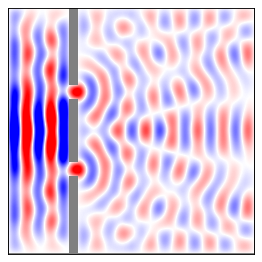

.......                                                                                   [100%]


<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

In [69]:
%%ipytest -qq

@pytest.mark.parametrize("nb, exp", [(1,1), (2,4), (3,9)])
def test_power2(nb, exp):
    assert nb ** 2 == exp, "Power of two is not correct"

# Just look at the visual output to make sure it looks like waves
# We will assume that this one works and test the others by comparing their results with this one
def test_get_Unew_default():
    # === Simulation parameters ===
    N              = 500   # Resolution
    boxsize        = 1.    # Size of the box
    c              = 1.    # Wave Speed
    tEnd           = 2.    # Simulation time
    plotRealTime   = False  # Set to True for real-time vizualisation
    plotFinal      = True

    # === Prepare output figure ===
    fig = plt.figure(figsize=(4,4), dpi=80)
    cmap = plt.cm.bwr
    cmap.set_bad('gray')

    # === Run main function ===
    result = simulate_finite_difference(boxsize, N, c, tEnd, plotRealTime, plotFinal, cmap, get_Unew_default)

testcases = [(500, 1., 1., 2., False, False, get_Unew_numexpr),
             (500, 1., 1., 2., False, False, get_Unew_numexpr2),
             (500, 1., 1., 2., False, False, get_Unew_numexpr3),
             (100, 1.5, 1., 2., False, False, get_Unew_numexpr),
             (100, 1.5, 1., 2., False, False, get_Unew_numexpr2),
             (100, 1.5, 1., 2., False, False, get_Unew_numexpr3)]
    
@pytest.mark.parametrize("N, boxsize, c, tEnd, plotRealTime, plotFinal, tested_get_Unew", testcases)
def test_get_Unew(N, boxsize, c, tEnd, plotRealTime, plotFinal, tested_get_Unew):
    fig = plt.figure(figsize=(6,6), dpi=80)
    cmap = plt.cm.bwr
    cmap.set_bad('gray')
    
    res1 = simulate_finite_difference(boxsize, N, c, tEnd, plotRealTime, plotFinal, cmap, get_Unew_default)
    res2 = simulate_finite_difference(boxsize, N, c, tEnd, plotRealTime, plotFinal, cmap, tested_get_Unew)
    np.testing.assert_allclose(res2, res1) # Compares both results